In [1]:
# === PARETO FRONT STUDIES NOTEBOOK #2 ===
# Author: Ana Sofia Calle Muñoz

# This notebook allows the user to plot the pareto front and trial trayectories trained on the pareto_analysis nb.
# A best_trials.csv will be generated and stored on the intermediate_dir path.

# == Before running:
# Configure the intermediate path and experiment name used in the pareto_analysis nb.
# Define the number of best trials you want to visualize on the "N_BEST_TO_PLOT" variable.
# Define the method to select the best trials (distance_to_pareto_center or distance_to_pareto) in the "dist" variable.

# == After running:
# After you observe the plotted trials trajectories and losses, you can filter erratic and high loss trial ids in the "excluded_ids" variable.
# Also, if you want to include an id that didn't pass the select methods, you can add it in the "forced_ids" variable.

# !!! Whenever you exclude or force a trial id, make sure you run the last block of code so the best_trials.csv is updated.

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
import keras
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import *
from keras.utils import Sequence
from keras.layers import Conv2D, MaxPooling2D
from qkeras import *

from keras.utils import Sequence
from keras.callbacks import EarlyStopping, Callback, LambdaCallback, CSVLogger

import numpy as np
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import copy
from tensorflow.keras.metrics import Mean
from ODG_v2 import OptimizedDataGenerator
from tabulate import tabulate

import os
import random
import csv
import pickle
import math

pi = 3.14159265359

maxval=1e9
minval=1e-9

2025-07-23 16:20:29.360646: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-23 16:20:29.360699: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-23 16:20:29.362260: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-23 16:20:29.370266: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-23 16:20:30.296325: W tensorflow/compiler/tf2

In [3]:
%load_ext autoreload
%autoreload 2

Total valid points loaded: 1500
Pareto front coordinates:
[[-4.65013981  0.28810459]
 [-4.64971542  0.28136799]]


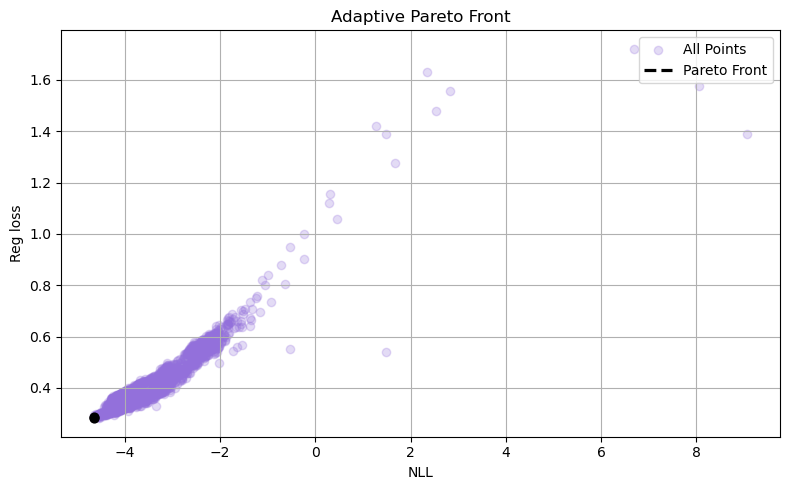

In [4]:
# ==Important paths you need to configure!
intermediate_dir = "/home/callea/smart-pixels-ml/intermediate_logs"
experiment_name = "adaptive_3&500"

exp_dir = os.path.join(intermediate_dir, experiment_name)
csv_path = os.path.join(exp_dir, "info.csv")

# Load the info.csv and detect the scheduler type
info_df = pd.read_csv(csv_path)
unique_schedulers = info_df["scheduler"].unique()
if len(unique_schedulers) == 1:
    scheduler_type = unique_schedulers[0]
else:
    scheduler_type = "Mixed" # Just in case there is an overwriting issue

# Checks if a point is dominated by any other point in the set.
# A point is dominated if there exists another point that is equal or better in both objectives (NLL and Reg), and strictly better in at least one.
def is_dominated(point, all_points):
    return any((q[0] <= point[0] and q[1] <= point[1] and (q[0] < point[0] or q[1] < point[1])) for q in all_points)

# Computes the Pareto front. It filters out all dominated points and returns the non-dominated ones.
def compute_pareto_from_points(points):
    points = np.array(points)
    pareto = []
    for p in points:
        if not is_dominated(p, points):
            pareto.append(p)
    pareto = np.array(pareto)
    
    if pareto.ndim == 1:
        pareto = pareto.reshape(-1, 2)
    
    if len(pareto) > 0:
        pareto = pareto[np.argsort(pareto[:, 0])]
    return pareto

# Load intermediate points from the pkl files
MAX_REG = 15
all_valid_points = []

for filename in os.listdir(os.path.join(intermediate_dir, experiment_name)):
    if filename.endswith("_intermediate.pkl"):
        inter_path = os.path.join(intermediate_dir, experiment_name, filename)
        if os.path.exists(inter_path):
            with open(inter_path, "rb") as f:
                inter = pickle.load(f)
                for point in inter:
                    if isinstance(point, tuple) and len(point) == 2:
                        nll, reg = point
                        
                        if isinstance(nll, (int, float)) and isinstance(reg, (int, float)):
                            if nll < 20:
                                all_valid_points.append((nll, reg))

all_valid_points = np.array(all_valid_points)
print(f"Total valid points loaded: {len(all_valid_points)}")

pareto_points = compute_pareto_from_points(all_valid_points)
print(f"Pareto front coordinates:\n{pareto_points}")

# This makes sure "all_valid_points" is 2D
if all_valid_points.ndim == 1:
    all_valid_points = all_valid_points.reshape(-1, 2)

plt.figure(figsize=(8, 5))
plt.scatter(pareto_points[:, 0], pareto_points[:, 1], color='black',marker='o', s=40, zorder=2)
plt.scatter(all_valid_points[:, 0], all_valid_points[:, 1], alpha=0.25, label="All Points", color="mediumpurple", zorder=1)
plt.plot(pareto_points[:, 0], pareto_points[:, 1], color='black', linestyle='--', linewidth=2.3, label="Pareto Front", zorder=2)
plt.xlabel("NLL")
plt.ylabel("Reg loss")
plt.title(f"{scheduler_type.capitalize()} Pareto Front")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

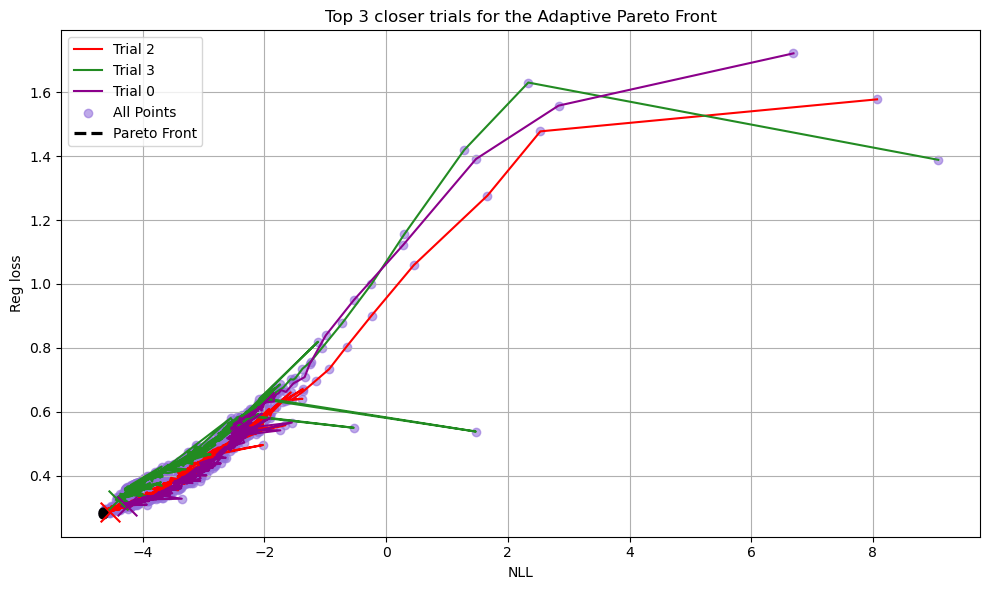

In [5]:
# == Set number of best trials you want to plot and save on a best_trials.csv.
N_BEST_TO_PLOT = 3

# Set trial ids you want to exclude or force to plot. Your csv will always have the # of trials set in "N_BEST_TO_PLOT".
excluded_ids = {}
forced_ids = {}

colors = ['red', 'forestgreen', 'darkmagenta', 'orange', 'blue']

# Selection methods to determine the best trials. You could add your own function. The "dist" variable calls the method.
# Calculates the centroid of the pareto front and measures the distance to a point
def distance_to_pareto_center(point, pareto):
    center = np.mean(pareto, axis=0)
    return np.linalg.norm(np.array(point) - center)

# Measures the distance between the general pareto front and a point
def distance_to_pareto(point, pareto):
    return np.min([np.linalg.norm(np.array(point) - np.array(p)) for p in pareto])

# Load all valid trials pkl files.
all_trajectories = []
all_final_points = []

for filename in os.listdir(os.path.join(intermediate_dir, experiment_name)):
    if filename.endswith("_intermediate.pkl"):
        trial_id = int(filename.split("_")[1])
        inter_path = os.path.join(intermediate_dir, experiment_name, filename)
        with open(inter_path, "rb") as f:
            trajectory = pickle.load(f)
        trajectory = np.array(trajectory)

        if trajectory.ndim == 2 and trajectory.shape[1] == 2:
            last_point = trajectory[-1]
            all_trajectories.append((trial_id, trajectory))
            all_final_points.append(last_point.tolist())

all_valid_points = np.vstack([traj for _, traj in all_trajectories])
pareto_points = compute_pareto_from_points(all_valid_points)

# Calculates the trial's distance of its last val loss epoch to the pareto front (depends on the selection method you use).
distances = []
for (trial_id, trajectory), final_point in zip(all_trajectories, all_final_points):

    # == dist variable that calls the selection methods.
    dist = distance_to_pareto(final_point, pareto_points)
    distances.append((dist, trial_id, trajectory))

# Code that sorts the distances and avoids getting bugs whenever you force or exlude a trial.
distances.sort(key=lambda x: x[0])

forced_ids = set(forced_ids)
excluded_ids = set(excluded_ids)
forced_entries = [entry for entry in distances if entry[1] in forced_ids]
filtered_distances = [entry for entry in distances if entry[1] not in excluded_ids and entry[1] not in forced_ids]

n_remaining = max(0, N_BEST_TO_PLOT - len(forced_entries))
selected = filtered_distances[:n_remaining] + forced_entries

selected = sorted(selected, key=lambda x: x[0])
selected_ids = [trial_id for _, trial_id, _ in selected]


plt.figure(figsize=(10, 6))
# Plots the trajectories for each best trial
for i, (dist, trial_id, trajectory) in enumerate(selected):
    color = colors[i % len(colors)]
    plt.plot(trajectory[:, 0], trajectory[:, 1], label=f"Trial {trial_id}", color=color)
    plt.scatter(trajectory[-1, 0], trajectory[-1, 1], color=color, marker='x', s=200, zorder=3)

# Plots valid points and the pareto front
plt.scatter(pareto_points[:, 0], pareto_points[:, 1], color='black', s=40, zorder=2)
plt.scatter(all_valid_points[:, 0], all_valid_points[:, 1], alpha=0.6, label="All Points", color="mediumpurple", zorder=1)
plt.plot(pareto_points[:, 0], pareto_points[:, 1], color='black', linestyle='--', linewidth=2.3, label="Pareto Front", zorder=2)

plt.xlabel("NLL")
plt.ylabel("Reg loss")
plt.title(f"Top {N_BEST_TO_PLOT} closer trials for the {scheduler_type.capitalize()} Pareto Front")
plt.legend()
plt.grid(True, zorder=0)
plt.tight_layout()
plt.show()

In [6]:
import csv
import os
import pandas as pd
from tabulate import tabulate

# Load and display selected best trials 
print(f"\n Best trials to the Pareto front (in order): {selected_ids}\n")

# Load CSV and map trial_id --> trial info
trial_info_map = {}
with open(csv_path, "r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        trial_info_map[int(row["trial_id"])] = row

# Save info for selected best trials
best_trials_info = []

ordered_keys = [
    "rank", "trial_id", "scheduler",
    "lambda_init", "lambda_final", "stop_threshold",
    "step", "patience", "sharpness",
    "epochs", "final_nll", "final_reg", "final_val_loss", "keras_val_loss"
]

for rank, trial_id in enumerate(selected_ids, 1):
    row = trial_info_map[trial_id]
    scheduler_type = row["scheduler"]

    info = {
        "rank": rank,
        "trial_id": int(row["trial_id"]),
        "scheduler": scheduler_type,
        "lambda_init": float(row["start"]),
        "epochs": int(row["max_epochs"]),
        "final_nll": float(row["final_nll"]),
        "final_reg": float(row["final_reg"]),
        "final_val_loss": float(row["final_val_loss"]),
        "keras_val_loss": float(row["keras_val_loss"])
    }

    # Optional params: only include them if they exist
    if "end" in row and row["end"] != "":
        info["lambda_final"] = float(row["end"])
    if "stop_threshold" in row and row["stop_threshold"] != "":
        info["stop_threshold"] = float(row["stop_threshold"])
    if "step" in row and row["step"] != "":
        info["step"] = float(row["step"])
    if "patience" in row and row["patience"] != "":
        info["patience"] = int(row["patience"])
    if "sharpness" in row and row["sharpness"] != "":
        info["sharpness"] = float(row["sharpness"])

    best_trials_info.append(info)

# Print best trials parameters
for info in best_trials_info:
    table_data = []
    for key in ordered_keys:
        # No imprimir el rank
        if key == "rank":
            continue

        if key in info:
            value = info[key]
            # Formatear según tipo
            if key == "step":
                value = f"{value:.4f}"
            elif "lambda" in key or "loss" in key or key in ["final_nll", "final_reg"]:
                value = f"{value:.4f}"
            elif key == "stop_threshold":
                value = f"{value:.2f}"
            table_data.append([key.replace("_", " ").capitalize(), value])
    
    print(f"\n Best trial #{info['rank']}:")
    print(tabulate(table_data, tablefmt="fancy_grid", colalign=("center", "center")))


best_trials_df = pd.DataFrame(best_trials_info)
columns_to_save = [k for k in ordered_keys if k in best_trials_df.columns]
best_trials_df = best_trials_df[columns_to_save]

output_csv_path = os.path.join(exp_dir, "best_trials.csv")
best_trials_df.to_csv(output_csv_path, index=False)
print(f"\nSaved {len(best_trials_info)} best trials to: {output_csv_path}")


 Best trials to the Pareto front (in order): [2, 3, 0]


 Best trial #1:
╒════════════════╤═════════════╕
│    Trial id    │      2      │
├────────────────┼─────────────┤
│   Scheduler    │  adaptive   │
├────────────────┼─────────────┤
│  Lambda init   │   2.1245    │
├────────────────┼─────────────┤
│  Lambda final  │   7.0582    │
├────────────────┼─────────────┤
│ Stop threshold │  -28614.28  │
├────────────────┼─────────────┤
│      Step      │   0.0675    │
├────────────────┼─────────────┤
│    Patience    │      4      │
├────────────────┼─────────────┤
│     Epochs     │     500     │
├────────────────┼─────────────┤
│   Final nll    │   -4.5320   │
├────────────────┼─────────────┤
│   Final reg    │   0.2865    │
├────────────────┼─────────────┤
│ Final val loss │   -3.0996   │
├────────────────┼─────────────┤
│ Keras val loss │ -14619.2832 │
╘════════════════╧═════════════╛

 Best trial #2:
╒════════════════╤═════════════╕
│    Trial id    │      3      │
├────────────────┼